# Introduction;
  * Firstly we will explore the dataset and we will make some visualizations.
  * We will create a new dataset which is about RFM analysis. With the dataset we are going to segment the customers with some properties.
  * We will use the SNOB algorithm for clustering.

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from oct2py import octave
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
octave.addpath('F:\\Git_Files\\Snob\\')

'.;C:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python39\\Lib\\site-packages\\oct2py;C:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python39\\Lib\\site-packages\\octave_kernel;C:\\Program Files\\GNU Octave\\Octave-7.2.0\\mingw64\\lib\\octave\\7.2.0\\site\\oct\\x86_64-w64-mingw32;C:\\Program Files\\GNU Octave\\Octave-7.2.0\\mingw64\\lib\\octave\\site\\oct\\api-v57\\x86_64-w64-mingw32;C:\\Program Files\\GNU Octave\\Octave-7.2.0\\mingw64\\lib\\octave\\site\\oct\\x86_64-w64-mingw32;C:\\Program Files\\GNU Octave\\Octave-7.2.0\\mingw64\\share\\octave\\7.2.0\\site\\m;C:\\Program Files\\GNU Octave\\Octave-7.2.0\\mingw64\\share\\octave\\site\\api-v57\\m;C:\\Program Files\\GNU Octave\\Octave-7.2.0\\mingw64\\share\\octave\\site\\m;C:\\Program Files\\GNU Octave\\Octave-7.2.0\\mingw64\\share\\octave\\site\\m\\startup;C:\\Program Files\\GNU Octave\\Octave-7.2.0\\mingw64\\lib\\octave\\7.2.0\\oct\\x86_64-w64-mingw32;C:\\Program Files\\GNU Octave\\Octave-7.2.0\\mingw64\\share\\octave\\7.2.0\\

In [2]:
data = pd.read_csv('F:/Git_Files/Customer Segmentation/sales_data_sample.csv',encoding='unicode_escape')
print("data shape is:", data.shape, "*"*50)
data.head()

data shape is: (2823, 25) **************************************************


ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
4        10159               49     100.00               14  5205.27   

         ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0   2/24/2003 0:00  Shipped       1         2     2003  ...   
1    5/7/2003 0:00  Shipped       2         5     2003  ...   
2    7/1/2003 0:00  Shipped       3         7     2003  ...   
3   8/25/2003 0:00  Shipped       3         8     2003  ...   
4  10/10/2003 0:00  Shipped       4        10     2003  ...   

                    ADDRESSLINE1  ADDRESSLINE2           CITY STATE  \
0        897 Long Airport Avenue           NaN            NYC    NY   
1             59 rue de l'Abbaye           NaN          Reims   NaN   
2  27 rue du Colonel Pierre Avia           NaN          Paris   NaN   
3             78934 Hillside Dr.           NaN       Pasadena    CA   
4                7734 Strong St.           NaN  San Francisco    CA   

  POSTALCODE COUNTRY TERRITORY CONTACTLASTNAME CONTACTFIRSTNAME DEALSIZE  
0      10022     USA       NaN              Yu             Kwai    Small  
1      51100  France      EMEA         Henriot             Paul    Small  
2      75508  France      EMEA        Da Cunha           Daniel   Medium  
3      90003     USA       NaN           Young            Julie   Medium  
4        NaN     USA       NaN           Brown            Julie   Medium  

[5 rows x 25 columns]

In [3]:
data.describe().T.style.background_gradient(cmap="Oranges")

In [4]:
# Total Unique Values of columns
nunique = pd.DataFrame(data[data.columns].nunique())
nunique.style.background_gradient(cmap="turbo")

In [5]:
# Total Missing Values Numbers of columns
isnull = pd.DataFrame(data.isnull().sum())
isnull.style.background_gradient(cmap="ocean")

In [6]:
fig = px.pie(data,names='COUNTRY',title='Country Pie Chart')
fig.show()

In [7]:
# Dropping 3 Columns with Nulls
addresline2_missing_value_rates = data["ADDRESSLINE2"].isnull().sum() * 100 / len(data)
state_missing_value_rates = data["STATE"].isnull().sum() * 100 / len(data)
terrıtory_missing_value_rates = data["TERRITORY"].isnull().sum() * 100 / len(data)

print("ADDRESSLINE2 missing value rates % : ",round(addresline2_missing_value_rates,3))
print("STATE missing value rates % : ",round(state_missing_value_rates,3))
print("TERRITORY missing value rates % : ",round(terrıtory_missing_value_rates,3))

data = data.drop(["ADDRESSLINE2","STATE","TERRITORY"], axis=1)

ADDRESSLINE2 missing value rates % :  89.302
STATE missing value rates % :  52.639
TERRITORY missing value rates % :  38.045


# Organizing the data about the date to provide the concept of recency, timing and innovation.

# For RFM Analysis
1. "SALES" column is for "monetory"
2. "ORDERDATE" column is for "recency"
3. "QUANTITYORDERED" column is for "frequency"

In [8]:
data["ORDERDATE"] = pd.to_datetime(data["ORDERDATE"]) 

print("Maximum Date is: ", data["ORDERDATE"].max())
print("Minimum Date is: ", data["ORDERDATE"].min())

Now = dt.datetime(2005,5,31)

Maximum Date is:  2005-05-31 00:00:00
Minimum Date is:  2003-01-06 00:00:00


In [9]:
data["recency_day"] = (Now - data["ORDERDATE"]).astype(str)
data[["recency_day","ORDERDATE"]].head()

recency_day  ORDERDATE
0    827 days 2003-02-24
1    755 days 2003-05-07
2    700 days 2003-07-01
3    645 days 2003-08-25
4    599 days 2003-10-10

In [10]:
data[["recency_day","B"]] = data["recency_day"].str.split(" ",expand = True)
data = data.drop(["B","ORDERDATE"], axis=1)
data[["recency_day"]].head()

recency_day
0         827
1         755
2         700
3         645
4         599

# Grouping total expenditures by Customer
* A customer can have multiple purchases or date variables. We can then average these values ​​and reach our final goal.

In [11]:
# Here, by choosing the min value for recency dat, I reach the information of the last time the customer made a transaction.
data_rfm = data.groupby(["CUSTOMERNAME"]).agg({"ORDERNUMBER" :"count","SALES": "sum","recency_day":"min"})  
data_rfm.rename(columns={'recency_day':'Recency','ORDERNUMBER':'Frequency','SALES':'Monetary'}, inplace=True)
data_rfm[["Frequency","Monetary", "Recency"]] = data_rfm[["Frequency","Monetary", "Recency"]].astype(int)

In [12]:
data_rfm.iloc[:5].style.background_gradient(cmap="Pastel1", low=0.50, high=1.0)

# Before and after Normalization using Log

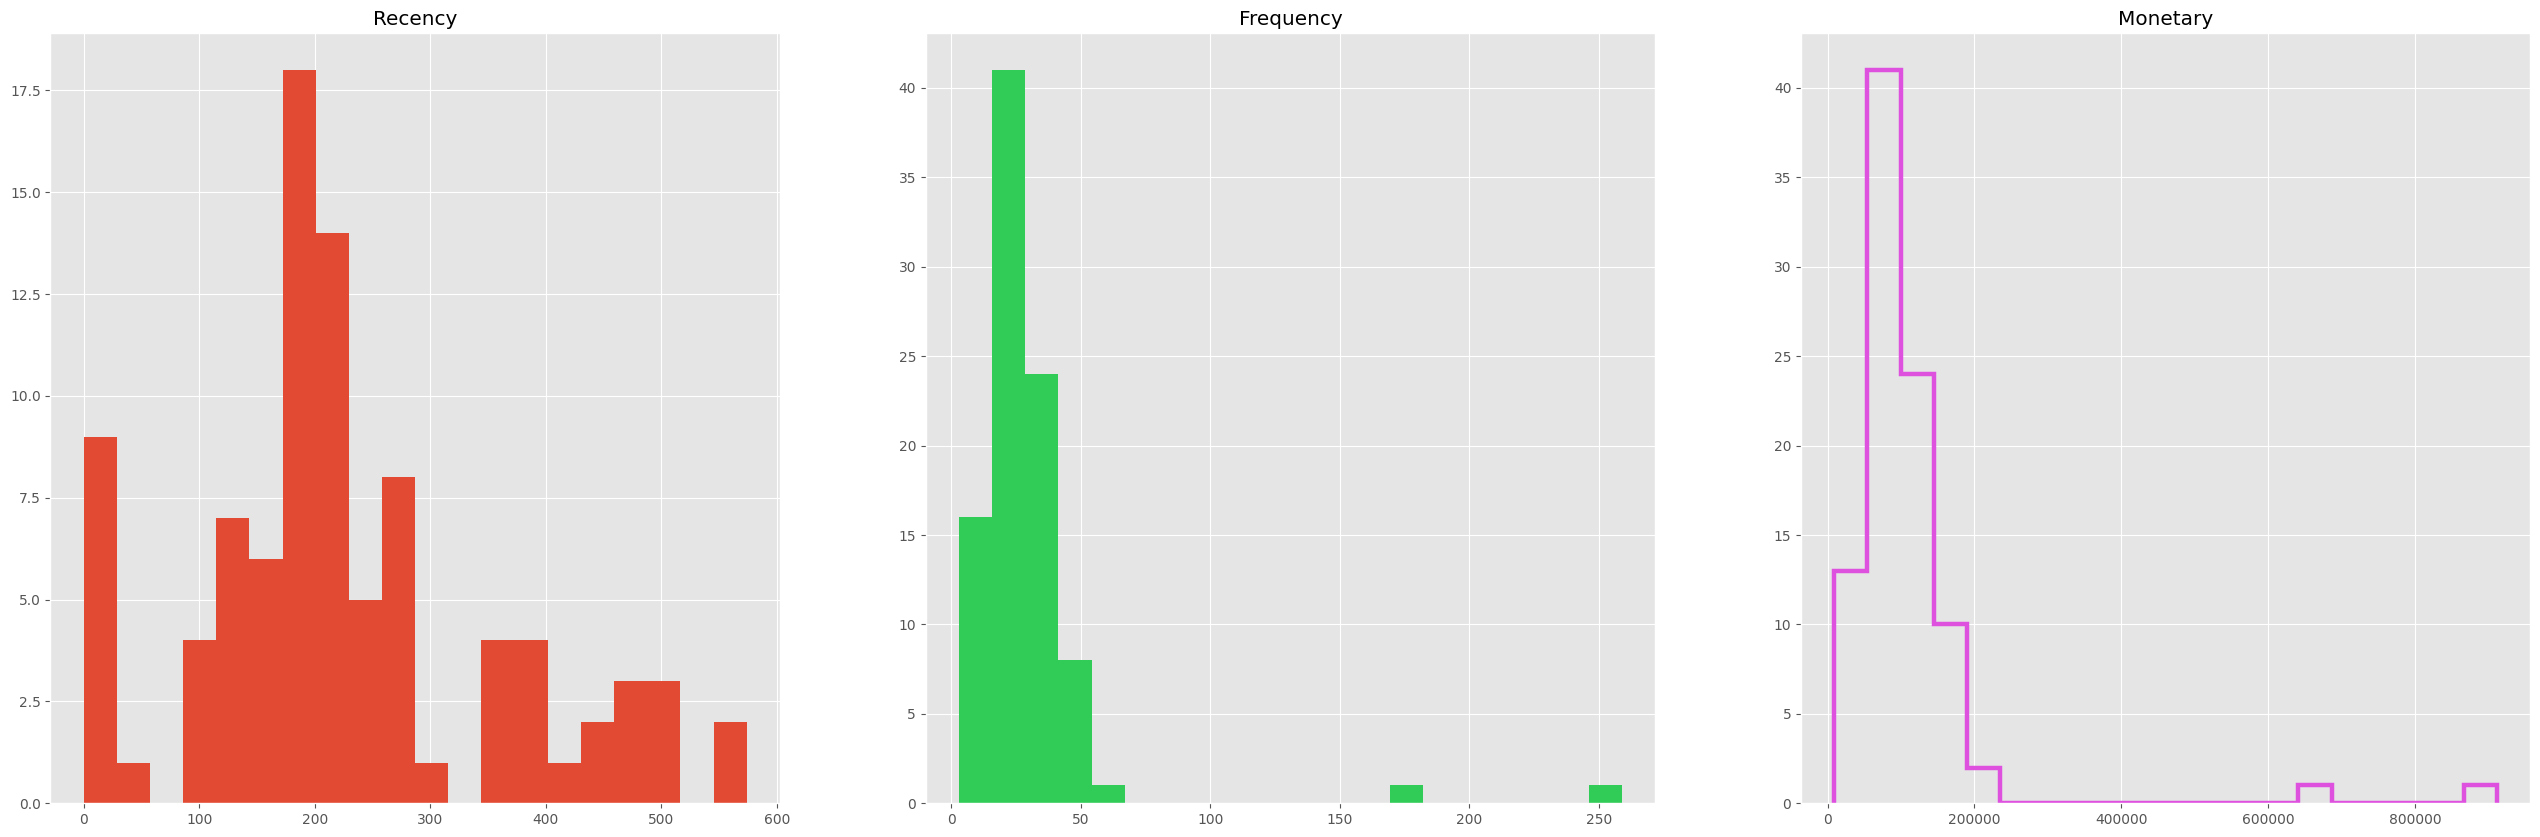

In [13]:
plt.style.use('ggplot')
fig, axarr = plt.subplots(1, 3, figsize=(32, 10))

axarr[0].hist(data_rfm['Recency'], bins=20, histtype= 'bar')
axarr[0].set_title("Recency")

axarr[1].hist(data_rfm['Frequency'], bins=20, histtype= 'stepfilled', color="#31CC57")
axarr[1].set_title("Frequency")

axarr[2].hist(data_rfm['Monetary'], bins=20,histtype= 'step', linewidth=3.2, color="#DE50DE")
axarr[2].set_title("Monetary")
plt.show()


In [14]:
data_rfm["Recency"] = np.log(data_rfm["Recency"]+1)
data_rfm["Frequency"] = np.log(data_rfm["Frequency"]+1)
data_rfm["Monetary"] = np.log(data_rfm["Monetary"]+1)

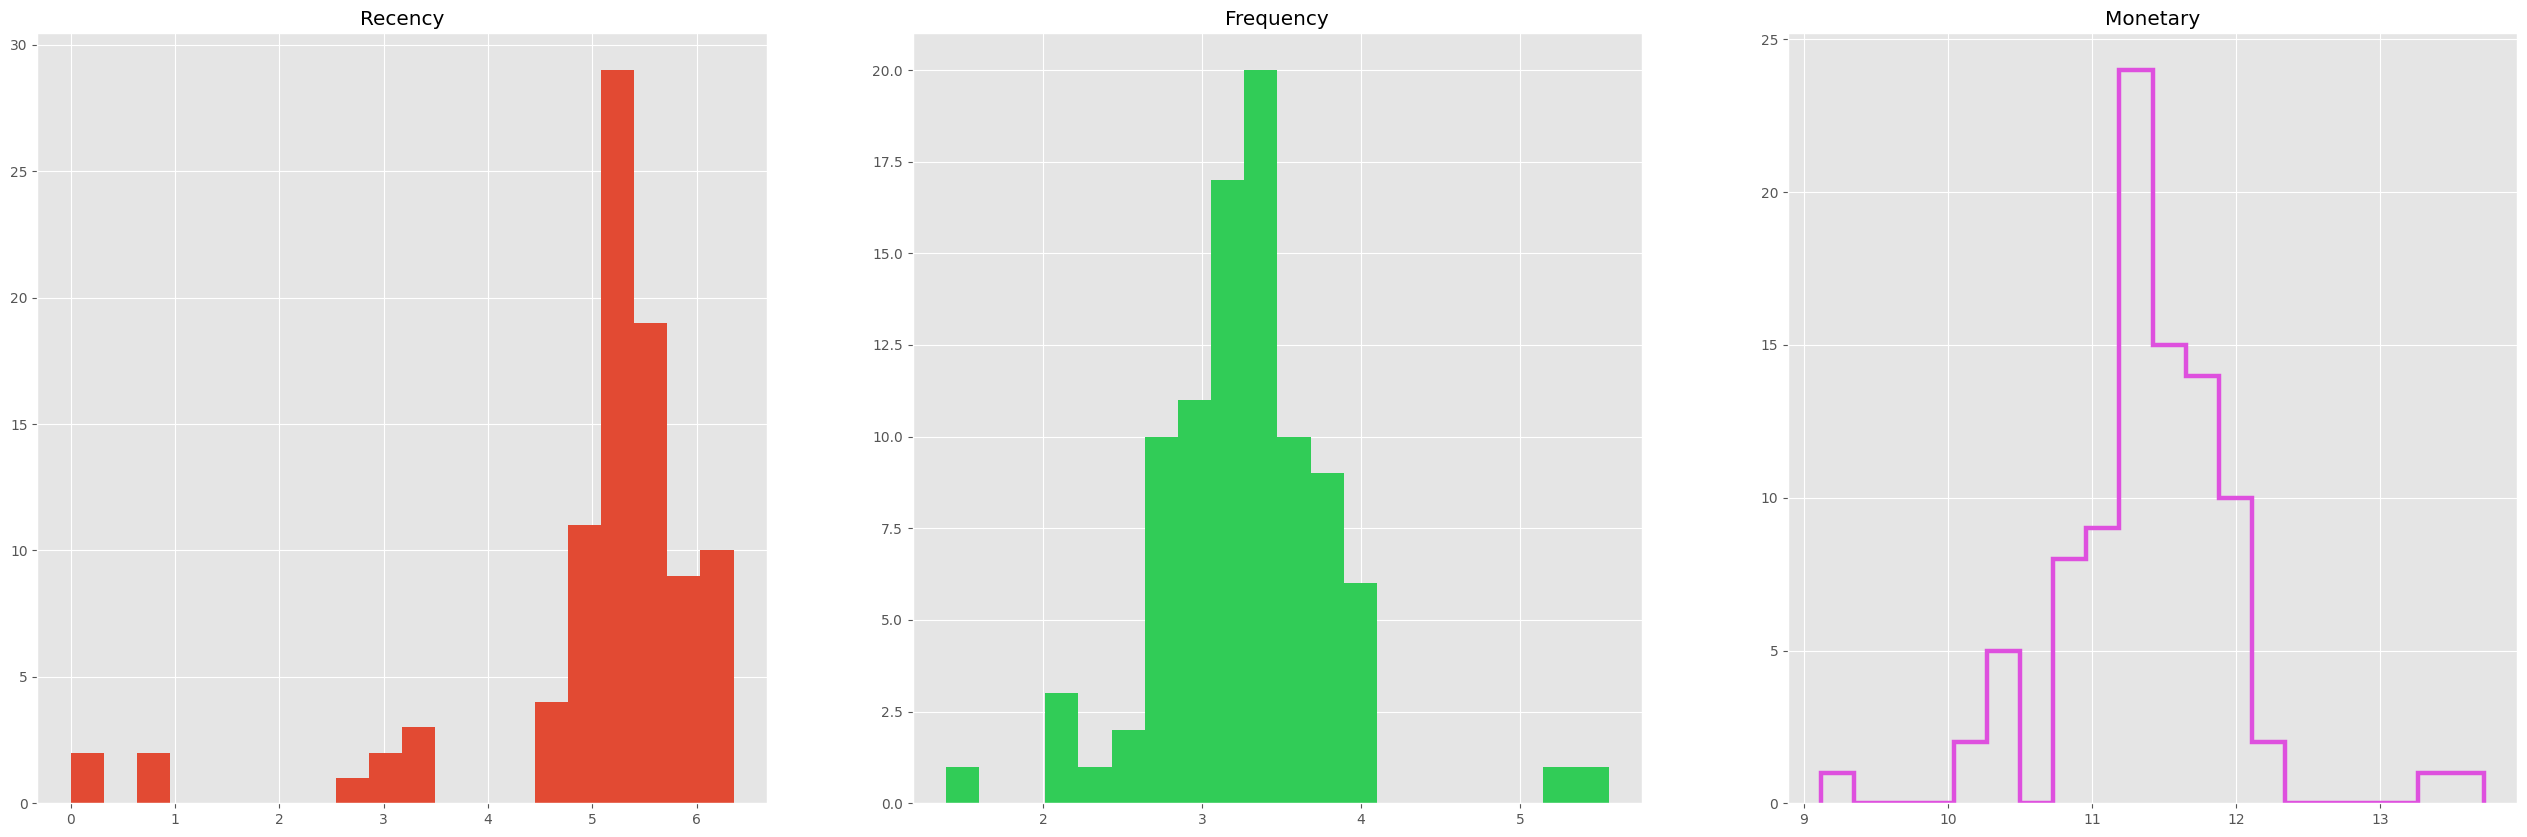

In [15]:
plt.style.use('ggplot')
fig, axarr = plt.subplots(1, 3, figsize=(32, 10))

axarr[0].hist(data_rfm['Recency'], bins=20, histtype= 'bar')
axarr[0].set_title("Recency")

axarr[1].hist(data_rfm['Frequency'], bins=20, histtype= 'stepfilled', color="#31CC57")
axarr[1].set_title("Frequency")

axarr[2].hist(data_rfm["Monetary"], bins=20,histtype= 'step', linewidth=3.2, color="#DE50DE")
axarr[2].set_title("Monetary")
plt.show()


# SNOB Python Implementaion Using Oct2Py

In [16]:
customer_names = list(data_rfm.index)
data_rfm.to_csv("data_for_snob.csv")

In [17]:
# Edit Clustering.m file to add the location of data_for_snob.csv and the Output Probabilities File
octave.Clustering()

    _pyeval at line 70 column 30

ans = 0.8668
|                          MML mixture modelling ver. 0.30                          |
|                     (c) Enes Makalic, Daniel F Schmidt. 2019-                     |
             Attempting to split...
             class   1: msglen =     209.59 nits
             Best      [  1]: msglen =     209.59 nits
             Attempting to add and re-assign...
             Best      [ADD]: msglen =     209.59 nits
             OUTCOME: add [   +209.59]
[Iter      1: #classes =  2, msglen =     209.59 nits, L =     113.93, cost = 95.66]
             Attempting to split...
             class   1: msglen =     231.35 nits
             class   2: msglen =     181.31 nits
             Best      [  2]: msglen =     181.31 nits
             Attempting to combine...
             class [  1,  2]: msglen =     912.21 nits
             Best  [  1,  2]: msglen =     912.21 nits
             Attempting to add and re-assign...
             Removing 1 class

array([[1.00000000e+000, 9.91019259e-308, 9.91019259e-308],
       [3.68247207e-308, 9.58537631e-001, 4.14623686e-002],
       [2.41739356e-309, 9.95733901e-001, 4.26609866e-003],
       [1.00000000e+000, 8.18974026e-308, 8.18974026e-308],
       [1.53099111e-306, 1.75406159e-004, 9.99824594e-001],
       [1.00000000e+000, 8.98764315e-306, 8.98764315e-306],
       [1.00000000e+000, 3.07525776e-307, 3.07525776e-307],
       [1.00000000e+000, 5.34093483e-308, 5.34093483e-308],
       [6.81784373e-309, 9.87790424e-001, 1.22095762e-002],
       [4.13516458e-309, 9.93882206e-001, 6.11779443e-003],
       [1.23581465e-306, 1.38491813e-003, 9.98615082e-001],
       [4.07422713e-309, 9.92543103e-001, 7.45689706e-003],
       [1.00000000e+000, 2.49798602e-307, 2.49798602e-307],
       [1.00000000e+000, 1.18817204e-308, 1.18817204e-308],
       [1.16669395e-305, 1.01637293e-015, 1.00000000e+000],
       [2.08831695e-307, 7.78384330e-001, 2.21615670e-001],
       [9.14502429e-307, 1.90134142e-001

In [18]:
# Reading Generated Probabilties File
prob = pd.read_csv('F:/Git_Files/Customer Segmentation/Probabilities.csv',header=None)
prob = prob.T
prob.columns = customer_names

In [19]:
# Assigining Clusters using Probabilities
buckets={}

for cust in customer_names:
    arr= list(prob[cust])
    bucket=arr.index(max(arr))
    try:
        buckets[bucket].append(cust)
    except:
        buckets[bucket]=[]
        buckets[bucket].append(cust)

cluster = pd.DataFrame(index=customer_names)

bucket_lst = []
for cust in customer_names:
    for bucket in range(len(prob)):
        if cust in buckets[bucket]:
            bucket_lst.append(bucket)
            
cluster['Snob Bucket'] = bucket_lst
cluster = cluster.reset_index()
cluster.columns = ['CUSTOMERNAME','Snob Bucket']

In [20]:
cluster

CUSTOMERNAME  Snob Bucket
0                AV Stores, Co.            0
1                  Alpha Cognac            1
2            Amica Models & Co.            1
3       Anna's Decorations, Ltd            0
4             Atelier graphique            2
..                          ...          ...
87              Vida Sport, Ltd            0
88              Vitachrome Inc.            1
89     Volvo Model Replicas, Co            0
90  West Coast Collectables Co.            1
91            giftsbymail.co.uk            1

[92 rows x 2 columns]

In [21]:
# Assign Clusters to Original Data
data = data.merge(cluster,how="left",on=["CUSTOMERNAME"])

In [22]:
data["Snob Bucket"].value_counts()

1    1358
2     747
0     718
Name: Snob Bucket, dtype: int64

# Dimensions Available
"PRODUCTCODE","CUSTOMERNAME","PHONE","ADDRESSLINE1","CITY",
"POSTALCODE","CONTACTLASTNAME","COUNTRY","CONTACTLASTNAME",
"CONTACTFIRSTNAME","DEALSIZE","recency_day","STATUS","PRODUCTLINE"

In [23]:
# Converting to Numeric for Dimensionality Reduction techniques
label_data = ["PRODUCTCODE","CUSTOMERNAME","PHONE","ADDRESSLINE1","CITY",
              "POSTALCODE","CONTACTLASTNAME","COUNTRY","CONTACTLASTNAME",
              "CONTACTFIRSTNAME","DEALSIZE","recency_day","STATUS","PRODUCTLINE"]
for i in label_data:
    data[i] =  data[i].astype(str)
    data[i] = le.fit_transform(data[i].values)
    
data.head()

ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  STATUS  \
0        10107               30      95.70                2  2871.00       5   
1        10121               34      81.35                5  2765.90       5   
2        10134               41      94.74                2  3884.34       5   
3        10145               45      83.26                6  3746.70       5   
4        10159               49     100.00               14  5205.27       5   

   QTR_ID  MONTH_ID  YEAR_ID  PRODUCTLINE  ...  PHONE  ADDRESSLINE1  CITY  \
0       1         2     2003            1  ...     48            57    42   
1       2         5     2003            1  ...     54            40    56   
2       3         7     2003            1  ...     16            21    52   
3       3         8     2003            1  ...     76            54    53   
4       4        10     2003            1  ...     77            51    59   

   POSTALCODE  COUNTRY  CONTACTLASTNAME  CONTACTFIRSTNAME  DEALSIZE  \
0           0       18               74                36         2   
1          27        6               21                54         2   
2          41        6                9                11         1   
3          49       18               73                31         1   
4          73       18               75                31         1   

   recency_day  Snob Bucket  
0          236            1  
1          220            1  
2          209            1  
3          198            1  
4          181            1  

[5 rows x 23 columns]

In [26]:
y = data["Snob Bucket"]

#PCA 
pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()),('pca', pca)])
X_pca = pipe.fit_transform(data.iloc[:,:23])

#t-sne
tsne = TSNE()
pipe = Pipeline([("scaler", StandardScaler()),('tsne', tsne)])
X_tsne = pipe.fit_transform(data.iloc[:,:23])

print(X_tsne.shape)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



(2823, 2)


C:\Users\User\AppData\Local\Temp\ipykernel_14228\2814374306.py:20: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



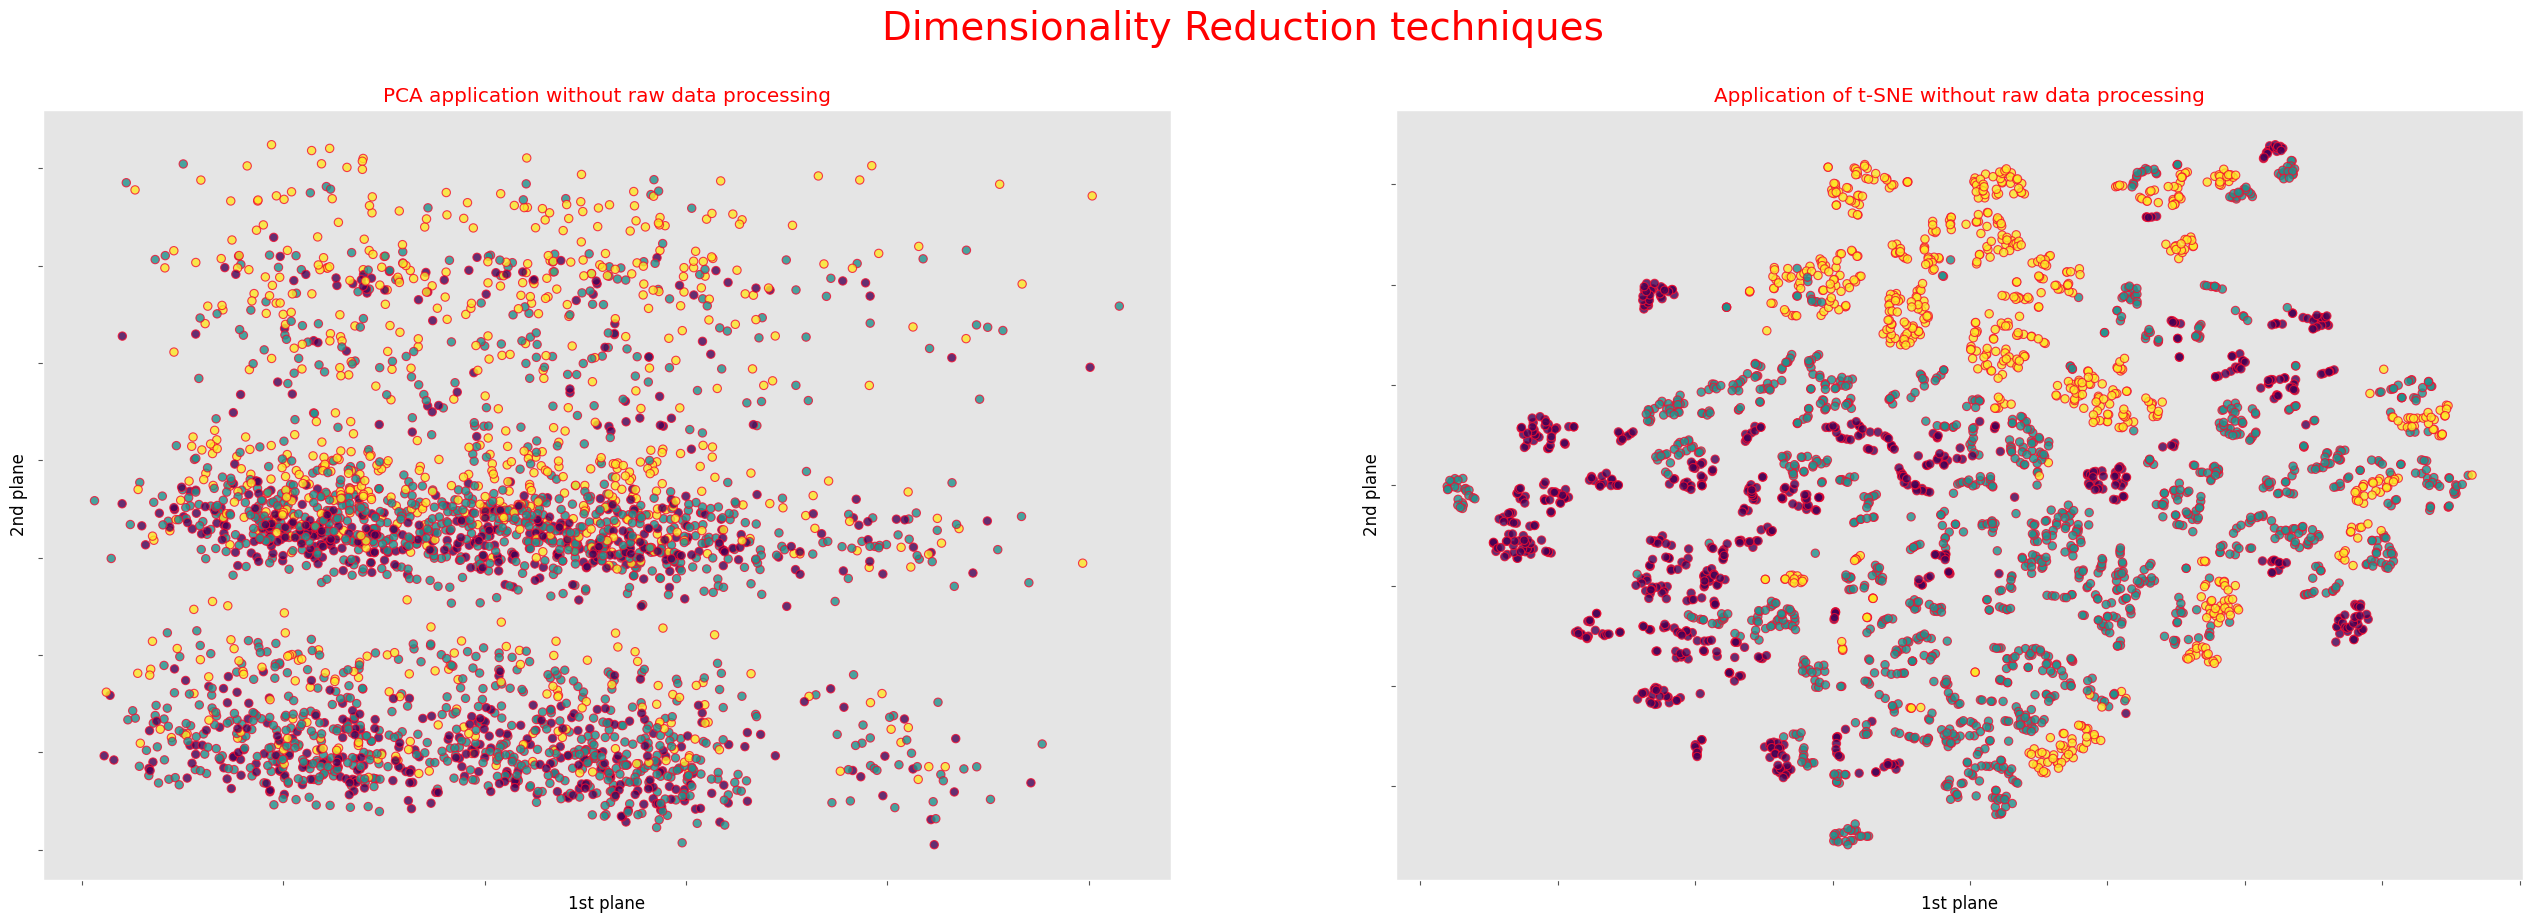

In [27]:
plt.style.use('ggplot')
fig, axarr = plt.subplots(1, 2, figsize=(32, 10))

fig.suptitle("Dimensionality Reduction techniques", color ="red", size = 28)
axarr[0].scatter(X_pca[:,0], X_pca[:,1],alpha=0.8,edgecolors="#F50D2F" ,linewidths=0.8, c=y)
axarr[0].set_title("PCA application without raw data processing" ,color="red")
axarr[0].set_ylabel("2nd plane", color ="black")
axarr[0].set_xlabel("1st plane", color ="black")
axarr[0].set_yticklabels([])
axarr[0].set_xticklabels([])
axarr[0].grid(False)

axarr[1].scatter(X_tsne[:,0], X_tsne[:,1],alpha=0.8,edgecolors="#F50D2F" ,linewidths=0.8, c=y)
axarr[1].set_title("Application of t-SNE without raw data processing" ,color="red")
axarr[1].set_ylabel("2nd plane", color ="black")
axarr[1].set_xlabel("1st plane", color ="black")
axarr[1].set_yticklabels([])
axarr[1].set_xticklabels([])
axarr[1].grid(False)
fig.show()

# Before and after the data were visualized by applying PCA and TSNE. In the 2nd part, meaningful results were searched by coloring according to the cluster variable, but could not be found.

# References
* https://www.kaggle.com/code/egeakyol/customer-segmentation-and-pca-t-sne/notebook